# LLM-Integrated Honeypot: Offline SSH Interaction Analysis

This notebook is an **offline, analysis** of attacker interactions with our  
**LLM-integrated SSH honeypot** deployed on Microsoft Azure.

All results are derived from **raw Beelzebub JSON logs** collected between  
**2025-12-02 and 2025-12-07**.  
No simulations, replays, or synthetic data are used.

**Focus of analysis:**
- Attacker commands routed through the LLM layer
- Behavioral patterns and automation
- Temporal clustering of LLM-mediated activity
- Practical limits of LLM-based honeypots


In [1]:
import gzip
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams.update({
    "figure.facecolor": "#2b2b2b",
    "axes.facecolor": "#2b2b2b",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
})


## Dataset Loading and Validation

The canonical dataset is a compressed line-delimited JSON log exported directly from
the Beelzebub container.

Each line represents a single honeypot event.  
Malformed entries are ignored to preserve ingestion robustness.


In [2]:
records = []

with gzip.open("beelzebub_full.json.gz", "rt", encoding="utf-8", errors="ignore") as f:
    for line in f:
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            pass

df = pd.DataFrame(records)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"]).sort_values("timestamp")

df.shape


(138366, 23)

## Baseline SSH Activity Context

This section establishes baseline SSH activity volume to provide context.
These counts are **not** the primary focus of the study and are included
only to contextualize LLM-mediated interaction rates.


In [3]:
ssh_sessions = df[df["msg"] == "New SSH Session"]
len(ssh_sessions)


3829

## LLM-Mediated Command Extraction

Beelzebub routes attacker-issued SSH commands to a local LLM backend.
When command execution fails or is intercepted, the attempted command
is embedded in log messages.

This analysis extracts those commands to study **how attackers probe
an AI-simulated system**.


In [4]:
def extract_llm_command(msg):
    if not isinstance(msg, str):
        return None
    m = re.search(r"ExecuteModel:\s*(.*?)(?:,|$)", msg)
    return m.group(1).strip() if m else None

df["llm_command"] = df["msg"].apply(extract_llm_command)
llm_df = df[df["llm_command"].notna()].copy()

llm_df.shape


(41035, 24)

## Most Frequent Attacker Commands Issued to the LLM

The following table lists the most common commands observed after attackers
reached the LLM layer.

Repetition indicates **automated fingerprinting behavior**, not manual interaction.


In [5]:
top_cmds = (
    llm_df["llm_command"]
    .value_counts()
    .head(20)
    .reset_index()
)

top_cmds.columns = ["Command", "Count"]
top_cmds.to_csv("top_llm_commands.csv", index=False)
top_cmds


,Command,Count
0,"nvidia-smi -q | grep ""Product Name"" | awk '{pr...",2899
1,lspci | egrep VGA && lspci | grep 3D,2729
2,"nvidia-smi -q | grep ""Product Name""",2729
3,uname -s -v -n -r -m,2729
4,uptime | grep -ohe 'up .*' | sed 's/,2729
5,"lscpu | egrep ""Model name:"" | cut -d ' ' -f 14-",2729
6,nproc,2729
7,uname -m,2729
8,curl ipinfo.io/org,2729
9,lspci | egrep VGA | grep Radeon | wc -l | head...,2729


## Temporal Distribution of LLM-Mediated Activity

LLM-mediated command attempts are aggregated hourly to identify
temporal clustering and automation patterns.

Sharp spikes typically correspond to **botnet bursts or mass scanning events**.


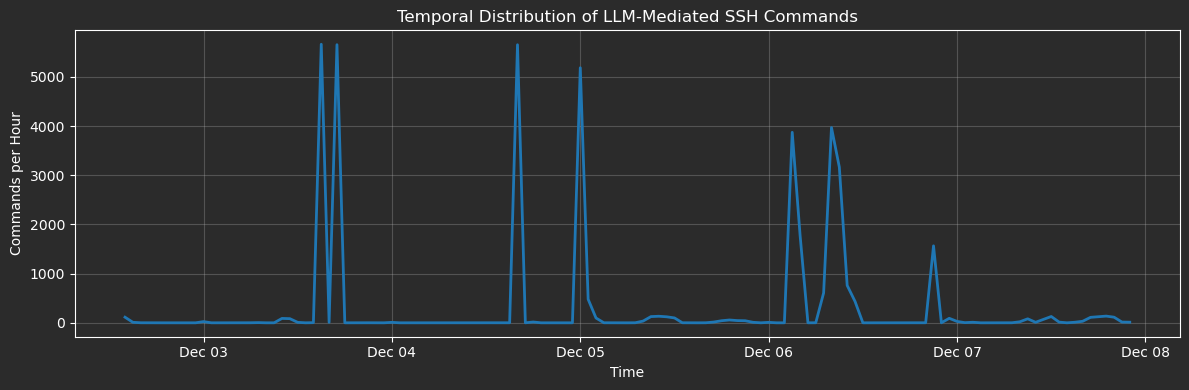

In [6]:
llm_ts = (
    llm_df
    .set_index("timestamp")
    .resample("1h")
    .size()
)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(llm_ts.index, llm_ts.values, linewidth=2)

ax.set_title("Temporal Distribution of LLM-Mediated SSH Commands")
ax.set_xlabel("Time")
ax.set_ylabel("Commands per Hour")

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("fig_llm_activity_timeline.png", dpi=300)
plt.show()


## Behavioral Classification of LLM Commands

Commands are categorized using lightweight keyword-based heuristics.
This approach prioritizes **interpretability and reproducibility**
over opaque machine-learning classifiers.

Categories reflect attacker intent rather than success.


In [7]:
def classify_behavior(cmd):
    c = cmd.lower()
    if any(k in c for k in ["uname", "/proc", "ls", "cat", "id", "whoami"]):
        return "Reconnaissance"
    if any(k in c for k in ["curl", "wget", "scp", "ftp", "http"]):
        return "Payload Fetch / Exfiltration"
    if any(k in c for k in ["rm ", "chmod", "chown", "kill", "shutdown"]):
        return "Host Manipulation"
    return "Other"

llm_df["behavior"] = llm_df["llm_command"].apply(classify_behavior)


## Distribution of LLM-Attempted Behaviors

This figure summarizes attacker intent once the LLM layer was reached.

A dominance of reconnaissance commands indicates that most attackers
treat the LLM as an **information oracle**, not an interactive shell.


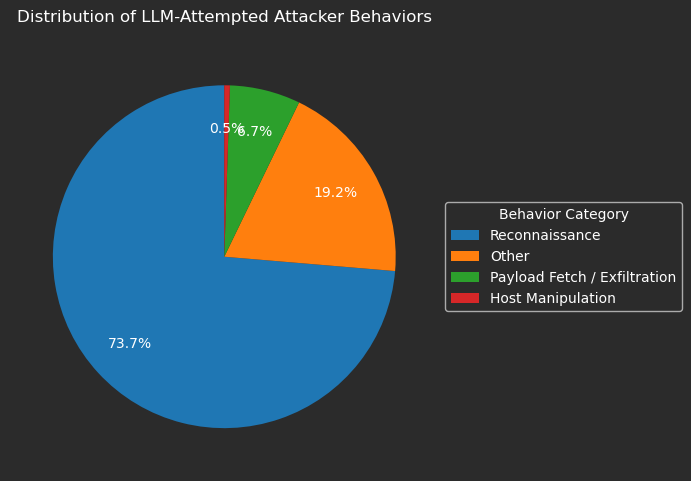

In [8]:
counts = llm_df["behavior"].value_counts()

fig, ax = plt.subplots(figsize=(7,7))
ax.pie(
    counts.values,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.75,
    textprops={"color": "white"}
)

ax.legend(
    counts.index,
    title="Behavior Category",
    loc="center left",
    bbox_to_anchor=(1.0, 0.5),
    labelcolor="white"
)

ax.set_title("Distribution of LLM-Attempted Attacker Behaviors", pad=15)
plt.tight_layout()
plt.savefig("fig_llm_behavior_distribution.png", dpi=300)
plt.show()


## Complexity of Attacker Commands

Command length is used as a proxy for interaction complexity.
Short, repetitive commands are characteristic of automated tooling,
while longer commands may indicate manual exploration.


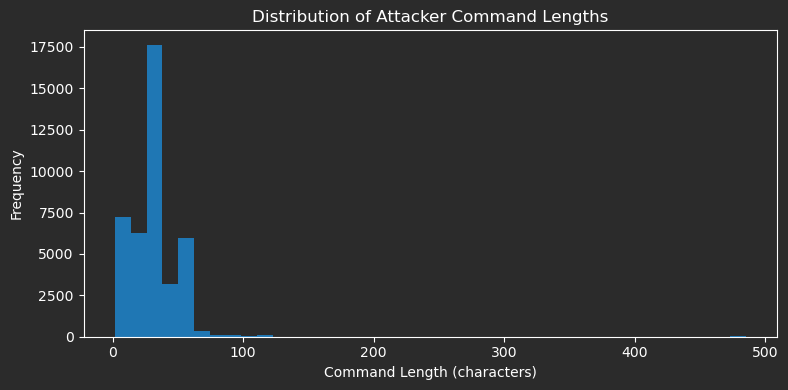

In [9]:
import matplotlib.pyplot as plt

llm_df["cmd_length"] = llm_df["llm_command"].str.len()

plt.figure(figsize=(8, 4))
plt.hist(llm_df["cmd_length"], bins=40)
plt.title("Distribution of Attacker Command Lengths")
plt.xlabel("Command Length (characters)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("fig_llm_command_length.png", dpi=300)
plt.show()


## Repeated Command Patterns Over Time

Highly repetitive commands appearing across distinct time windows
suggest reuse of identical attack tooling across multiple sources.


<ipython-input-10-3a1b92c0c2ca>:8: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()


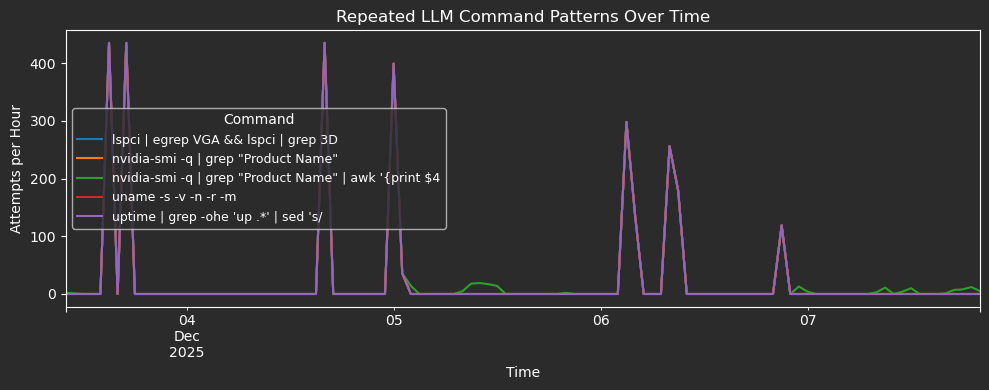

In [10]:
top_cmds = llm_df["llm_command"].value_counts().head(5).index

cmd_ts = (
    llm_df[llm_df["llm_command"].isin(top_cmds)]
    .set_index("timestamp")
    .groupby("llm_command")
    .resample("1h")
    .size()
    .unstack(level=0)
    .fillna(0)
)

cmd_ts.plot(figsize=(10, 4))
plt.title("Repeated LLM Command Patterns Over Time")
plt.xlabel("Time")
plt.ylabel("Attempts per Hour")
plt.legend(title="Command", fontsize=9)
plt.tight_layout()
plt.savefig("fig_llm_repeated_commands.png", dpi=300)
plt.show()


## Initial LLM Command per SSH Session

Analyzing the first command issued after reaching the LLM reveals
attacker priorities during initial probing.

First commands are strong indicators of **automated reconnaissance workflows**.
